# Data Processing & Analysis

In [34]:
import pandas as pd
import joblib
import logging
import sys
import seaborn as sns
from geopy.distance import distance
from util.timer import Timer
from math import cos, radians, sin, sqrt

## Setup

In [3]:
raw_dataset = pd.read_csv('data/train.csv')

In [35]:
logger = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

Since the dataset is too large to function on a regular computer, I will be splitting the dataset up into a <br>
random sample of 10 and performing data cleaning, feature engineering, and analysis on the smaller random <br>
sample.

In [36]:
def generate_random_samples(df, n, frac, name="raw_data/random_sample_{}.joblib"):
    for i in range(0,n):
        random_sample = df.sample(frac=frac)
        joblib.dump(random_sample, name.format(i))

In [ ]:
generate_random_samples(raw_dataset, n=10, frac=0.01, name="raw_data/small_sample_{}.joblib")
generate_random_samples(raw_dataset, n=5, frac=0.05, name="raw_data/medium_sample_{}.joblib")
generate_random_samples(raw_dataset, n=2, frac=0.1, name="raw_data/large_sample_{}.joblib")

## Data Cleaning

In [47]:
def clean(df):
    # Delimiter lats and lons to NY only
    df = df[(-76 <= df['pickup_longitude']) & (df['pickup_longitude'] <= -72)]
    df = df[(-76 <= df['dropoff_longitude']) & (df['dropoff_longitude'] <= -72)]
    df = df[(38 <= df['pickup_latitude']) & (df['pickup_latitude'] <= 42)]
    df = df[(38 <= df['dropoff_latitude']) & (df['dropoff_latitude'] <= 42)]
    # Remove possible outliers
    df = df[(0 < df['fare_amount']) & (df['fare_amount'] <= 250)]
    df = df[df['passenger_count'] > 0 & df['passenger_count'] < 6]
    
    # Remove inconsistent values
    df = df[(df['dropoff_longitude'] != df['pickup_longitude'])]
    df = df[(df['dropoff_latitude'] != df['pickup_latitude'])]
    
    return df

In [37]:
raw_dataset = joblib.load('raw_data/medium_sample_0.joblib')
cleaned_dataset = clean(raw_dataset)

## Feature Engineering

In [29]:
def add_time_features(df):
    df['pickup_datetime'] =  pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S %Z')
    
    df['year'] = df['pickup_datetime'].apply(lambda x: x.year)
    df['month'] = df['pickup_datetime'].apply(lambda x: x.month)
    df['day'] = df['pickup_datetime'].apply(lambda x: x.day)
    df['hour'] = df['pickup_datetime'].apply(lambda x: x.hour)
    
    df = df.drop('pickup_datetime', axis=1)
    
    return df

def add_distance_features(df):
    df['distance'] = df.apply(lambda row : calculate_distance(row['pickup_longitude'],
       row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)
    
    return df
    
def calculate_distance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    # Define the two points
    pickup = (pickup_latitude, pickup_longitude)
    dropoff = (dropoff_latitude, dropoff_longitude)
    
    #Return distance in meters
    return distance(pickup, dropoff).kilometers  

# Ellipsoid parameters: semi major axis in metres, reciprocal flattening.
GRS80 = 6378137, 298.257222100882711
WGS84 = 6378137, 298.257223563

def geodetic_to_geocentric(ellipsoid, latitude, longitude, height):
    """Return geocentric (Cartesian) Coordinates x, y, z corresponding to
    the geodetic coordinates given by latitude and longitude (in
    degrees) and height above ellipsoid. The ellipsoid must be
    specified by a pair (semi-major axis, reciprocal flattening).

    """
    φ = radians(latitude)
    λ = radians(longitude)
    sin_φ = sin(φ)
    a, rf = ellipsoid           # semi-major axis, reciprocal flattening
    e2 = 1 - (1 - 1 / rf) ** 2  # eccentricity squared
    n = a / sqrt(1 - e2 * sin_φ ** 2) # prime vertical radius
    r = (n + height) * cos(φ)   # perpendicular distance from z axis
    x = r * cos(λ)
    y = r * sin(λ)
    z = (n * (1 - e2) + height) * sin_φ
    return x, y, z

def add_geocentric_features(df):
    cols = df.columns.tolist()
    cols = cols + ['x_pickup', 'y_pickup', 'z_pickup']
    cols = cols + ['x_dropoff', 'y_dropoff', 'z_dropoff']
    h = 124
    series_pickup = df.apply(lambda row : geodetic_to_geocentric(WGS84, 
                                                      row['pickup_latitude'], 
                                                      row['pickup_longitude'], 
                                                      h), axis=1).tolist()
    df_pickup = pd.DataFrame(series_pickup, columns=['x_pickup', 'y_pickup', 'z_pickup'])
    
    series_dropoff = df.apply(lambda row : geodetic_to_geocentric(WGS84, 
                                                      row['dropoff_latitude'], 
                                                      row['dropoff_longitude'], 
                                                      h), axis=1).tolist()
    df_dropoff = pd.DataFrame(series_dropoff, columns=['x_dropoff', 'y_dropoff', 'z_dropoff'])
    
    
    df.reset_index(drop=True, inplace=True)
    df_pickup.reset_index(drop=True, inplace=True)
    df_dropoff.reset_index(drop=True, inplace=True)
    df_result = pd.concat([df, df_pickup, df_dropoff], axis=1, ignore_index=True)
    df_result.columns=cols
        
    return df_result

In [33]:
with Timer(logger, "adding time features"):
    dataset = add_time_features(cleaned_dataset)
    
with Timer(logger, "adding distance features"):
    dataset = add_distance_features(dataset)

with Timer(logger, "adding geocentric features"):
    dataset = add_geocentric_features(dataset)

INFO:__main__:Started adding time features
INFO:__main__:Finished adding time features in 1.01 seconds.
INFO:__main__:Started adding distance features
INFO:__main__:Finished adding distance features in 495.23 seconds.
INFO:__main__:Started adding geocentric features
INFO:__main__:Finished adding geocentric features in 87.61 seconds.


In [40]:
joblib.dump(dataset, 'medium_sample_0_w_features.joblib')

['medium_sample_0_w_features.joblib']

In [41]:
corr = dataset.corr()

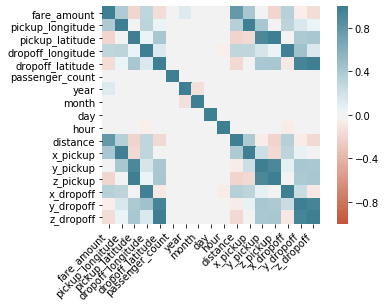

In [42]:
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [45]:
dataset.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,distance,x_pickup,y_pickup,z_pickup,x_dropoff,y_dropoff,z_dropoff
count,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06,2.673313e+06
mean,1.131929e+01,-7.397560e+01,4.075091e+01,-7.397473e+01,4.075123e+01,1.692054e+00,2.011743e+03,6.266683e+00,1.570968e+01,1.351646e+01,3.383560e+00,1.335731e+06,-4.650771e+06,4.141587e+06,1.335795e+06,-4.650728e+06,4.141615e+06
std,9.554126e+00,3.801579e-02,3.012036e-02,3.658090e-02,3.363187e-02,1.319616e+00,1.867334e+00,3.436274e+00,8.679540e+00,6.517416e+00,4.109586e+00,3.130760e+03,2.293794e+03,2.536858e+03,2.948288e+03,2.604029e+03,2.832502e+03
min,1.000000e-02,-7.583662e+01,3.847367e+01,-7.578276e+01,3.803978e+01,1.000000e+00,2.009000e+03,1.000000e+00,1.000000e+00,0.000000e+00,1.392209e-04,1.183529e+06,-4.834792e+06,3.946818e+06,1.184696e+06,-4.819483e+06,3.908999e+06
25%,6.000000e+00,-7.399227e+01,4.073665e+01,-7.399159e+01,4.073564e+01,1.000000e+00,2.010000e+03,3.000000e+00,8.000000e+00,9.000000e+00,1.279412e+00,1.334468e+06,-4.652199e+06,4.140388e+06,1.334516e+06,-4.652199e+06,4.140304e+06
50%,8.500000e+00,-7.398211e+01,4.075346e+01,-7.398063e+01,4.075393e+01,1.000000e+00,2.012000e+03,6.000000e+00,1.600000e+01,1.400000e+01,2.178372e+00,1.335159e+06,-4.650718e+06,4.141802e+06,1.335274e+06,-4.650666e+06,4.141842e+06
75%,1.250000e+01,-7.396843e+01,4.076759e+01,-7.396557e+01,4.076841e+01,2.000000e+00,2.013000e+03,9.000000e+00,2.300000e+01,1.900000e+01,3.936682e+00,1.336057e+06,-4.649483e+06,4.142991e+06,1.336262e+06,-4.649301e+06,4.143060e+06
max,2.500000e+02,-7.206292e+01,4.195009e+01,-7.205459e+01,4.196111e+01,2.080000e+02,2.015000e+03,1.200000e+01,3.100000e+01,2.300000e+01,2.721788e+02,1.524154e+06,-4.524496e+06,4.241565e+06,1.502148e+06,-4.523863e+06,4.242476e+06


In [49]:
dataset = dataset[(dataset['passenger_count'] > 0) & (dataset['passenger_count'] < 6)]

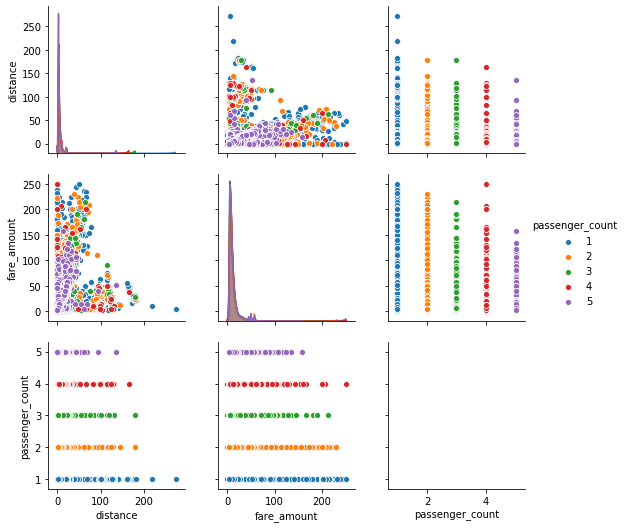

In [50]:
sns.pairplot(dataset[['distance', 'fare_amount', 'passenger_count']], hue="passenger_count")